In [2]:
# jupyter notebook python code for personal challenge assignment: Task 1 and Task 2
# both tasks uses Light Gradient Boost Model LightGBM to make the requested prediction
# Content:
#1. Liberaries & Functions:
#   1.1 encode_categorical_features: to encode categorcial features: Division Name and so on
#   1.2 preprocess_text_features: using TF-IDF technique to vectorize text data: Title and Review Title
#   1.3 prepare_features_and_target: put together the processed features to fit in the model
#   1.4 train_and_save_lightgbm: does the grid search, fits the model and saves the best model
#   1.5 evaluate_model: evaluate the fit model's accuracy, print the resuts and visualize Confusion Matrix

#2. Main:
#   2.1 Task 1: fits the prediction model, saves the best model and print the accuracy check on test dataset
#   2.2 Task 2: fits the prediction model, saves the best model and print the accuracy check on test dataset


In [3]:
### Importing the required liberaries

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib

####### 1.1 - encoding Categorical Features ###############
def encode_categorical_features(train_df, test_df, categorical_cols):

    label_encoders = {}  # Store label encoders for future use

    for col in categorical_cols:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))

        # Handle unseen categories in the test set by assigning -1
        test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

        label_encoders[col] = le  # Store the trained encoder

    return train_df, test_df, label_encoders

######## 1.2. Preprocessing text features ####################
#########################################################################################################################
def preprocess_text_features(train_df, test_df, max_tfidf_features=5000):

    # Handle missing values in text columns
    imputer = SimpleImputer(strategy='most_frequent')
    train_df["Title"] = train_df["Title"].fillna("")
    train_df["Review Text"] = train_df["Review Text"].fillna("")
    test_df["Title"]=test_df["Title"].fillna("")
    test_df["Review Text"]= test_df["Review Text"].fillna("")



    # Convert text data into TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_features=max_tfidf_features, stop_words='english')
    train_tfidf = tfidf_vectorizer.fit_transform(train_df["Review Text"] + " " + train_df["Title"])
    test_tfidf = tfidf_vectorizer.transform(test_df["Review Text"] + " " + test_df["Title"])

    return train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer

### 1.3. Preparing features and target for the related task
######################################################################################################

def prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf, target_col, exclude_columns):
        
    # Default columns to exclude
    default_exclude = ["Review Text", "Title", target_col]
    
    # If exclude_columns is provided, extend the default exclusion list
    if exclude_columns:
        default_exclude.extend(exclude_columns)

    # Define structured features, excluding specified columns
    structured_features = [col for col in train_df.columns if col not in default_exclude]

    # Combine TF-IDF text features with structured features
    X_train = hstack((train_tfidf, train_df[structured_features]))
    y_train = train_df[target_col]

    X_test = hstack((test_tfidf, test_df[structured_features]))
    y_test = test_df[target_col]

    return X_train, y_train, X_test, y_test


### 1.4. run the grid search and fit the model: LightGBM  #############
#######################################################################################
def train_and_save_lightgbm(X_train, y_train, X_test, param_grid, lgb_clf, model_filename):


    # Convert sparse matrices to DataFrame with feature names
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
    X_train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
    X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_df, y_train)

    # Print best model parameters
    print("Best Model Parameters:", grid_search.best_params_)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save the trained LightGBM model
    joblib.dump(best_model, model_filename)
    print(f"Model saved successfully as {model_filename}")

    return best_model, grid_search, X_test_df


### 1.5. Predictin evaluation #############
############################################################
def evaluate_model(best_model, X_test, y_test, class_labels):

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_f1 = f1_score(y_test, y_pred, average='weighted')

    # Generate classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:\n")
    print(class_report)

    if y_test.name == 'Rating':
        print(f"Final Accuracy: {accuracy:.2f}")
    else:
        print(f"Final Weighted F1-score: {accuracy_f1:.2f}")

    # Visualization - Confusion Matrix
    plt.figure(figsize=(6, 5))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title("Confusion Matrix for LightGBM Model")
    plt.show()

    return accuracy, class_report


[LightGBM] [Info] Number of positive: 15467, number of negative: 3321
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103705
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.823238 -> initscore=1.538443
[LightGBM] [Info] Start training from score 1.538443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Model Parameters: {'learning_rate': 0.05, 'max_depth': 20, 'n

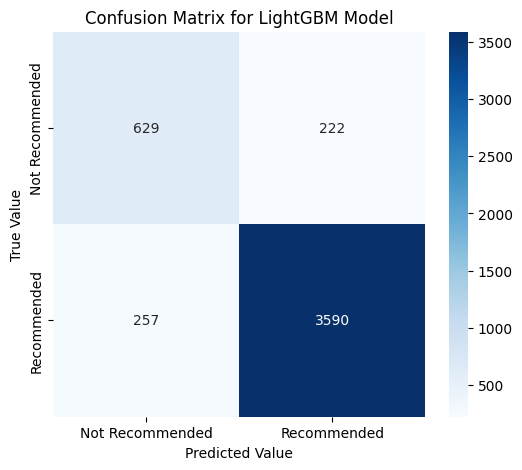

In [4]:
### 2.1 Task 1. Predicting "Recommended IND" - by LightGBM model

############### Task 1 ###########################################

# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/test_data.csv")

# Define categorical columns
categorical_cols = ["Division Name", "Department Name", "Class Name"]

# Encode categorical features
train_df, test_df, label_encoders = encode_categorical_features(train_df, test_df, categorical_cols)

# Preprocess text features and transform using TF-IDF
train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer = preprocess_text_features(train_df, test_df)

# Train LightGBM Model with Hyperparameter Tuning
# To save processing time. the best pramas set are commented here based on the previous search
param_grid = {
    'num_leaves': [31, 50, 100],            #50
    'learning_rate': [0.01, 0.05, 0.1],     #0.05
    'n_estimators': [100, 200, 500],        #500
    'max_depth': [-1, 10, 20]               #-1
}


# Prepare features and target variables
X_train, y_train, X_test, y_test = prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf,target_col="Recommended IND", exclude_columns=["Clothing ID","Rating"])

# Train model and save it
lgb_clf = lgb.LGBMClassifier(random_state=42,is_unbalance =True) # class_weight='balanced'
best_lgb_model, grid_search_results, X_test_df = train_and_save_lightgbm(X_train, y_train, X_test, param_grid, lgb_clf, "lightgbm_task1_model.pkl")


# Evaluate the best LightGBM model
accuracy, class_report = evaluate_model(best_lgb_model, X_test_df, y_test,["Not Recommended", "Recommended"])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103707
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2035
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Best Model Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 100}
Model saved successfully as lightgbm_task2_model.pkl
Classification Report:

              precision    recall  f1-score   support

           1       0.34      0.29      0.31       153
           2       0.38      0.37      0.38       317
           3       0.47      

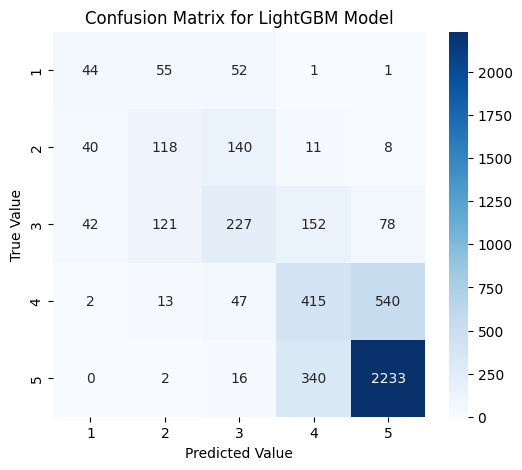

In [6]:
### 2.2 Task 2. Predicting "Rating" - by LightGBM model
############## Task 2 ###############################
# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/test_data.csv")

# Define categorical columns
categorical_cols = ["Division Name", "Department Name", "Class Name"]

# Encode categorical features
train_df, test_df, label_encoders = encode_categorical_features(train_df, test_df, categorical_cols)

# Preprocess text features and transform using TF-IDF
train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer = preprocess_text_features(train_df, test_df)

# Train LightGBM Model with Hyperparameter Tuning
# The best paramters set based on previous search are commneted here to reduce the process time
param_grid = {
    'num_leaves': [31, 50, 100],            #100
    'learning_rate': [0.01, 0.05, 0.1],     #0.05
    'n_estimators': [100, 200, 500],        #500
    'max_depth': [-1, 10, 20]               #-1
}

# Prepare features and target variables
X_train, y_train, X_test, y_test = prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf, target_col="Rating", exclude_columns=["Clothing ID"])

# Train model and save it
lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced') 
best_lgb_model, grid_search_results, X_test_df = train_and_save_lightgbm(X_train, y_train, X_test, param_grid, lgb_clf, "lightgbm_task2_model.pkl")

# Evaluate the best LightGBM model
accuracy, class_report = evaluate_model(best_lgb_model, X_test_df, y_test, ["1", "2", "3", "4", "5"])